In [ ]:
import os
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from skimage import color
from skimage import data, transform
from sklearn.datasets import fetch_lfw_people
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain

faces = fetch_lfw_people()
positive_patches = faces.images


imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

# Chargement des données
y_train = [True]*21 + [False]*42
y_test = [True]*3 + [False]*3
 
hog_features_train = []
for file in os.listdir(directory_train):
    if file.endswith('.jpg'):
        image = skimage.io.imread(os.path.join(directory_train, file))
        image_resized = resize(image, (128, 128), anti_aliasing=True)
        image_resized_gray = rgb2gray(image_resized)
        fd = hog(image_resized_gray, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2))
        hog_features_train.append(fd)

hog_features_test = []
for file in os.listdir(directory_test):
    if file.endswith('.jpg'):
        image = skimage.io.imread(os.path.join(directory_test, file))
        image_resized = resize(image, (128, 128), anti_aliasing=True)
        image_resized_gray = rgb2gray(image_resized)
        fd = hog(image_resized_gray, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2))
        hog_features_test.append(fd)
        
X_train_hog = np.vstack(hog_features_train)
X_test_hog = np.vstack(hog_features_test)
        
classifier = SVC()
classifier.fit(X_train_hog, y_train)

y_pred = classifier.predict(X_test_hog)
print(y_pred)
print(classification_report(y_test, y_pred, zero_division='raise'))
        
        

<ipython-input-5-ee60141ae238>:22: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


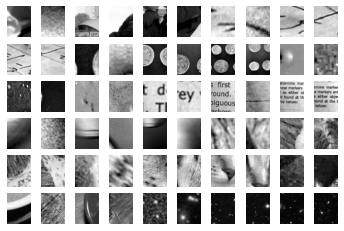